In [1]:
# set up enviroment
from __future__ import division
import sys
import numpy as np
import pandas as pd 
import scipy
import importlib
import scanpy as sc

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
from matplotlib_venn import venn2

from sklearn.manifold import TSNE
import sklearn

pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
# sc.logging.print_versions()
sc.settings.set_figure_params(figsize=(6,7),dpi_save=600)

In [3]:
adata_all = sc.read_h5ad('../data/adata_all_panPN_annotated_final.h5ad')
adata_all

AnnData object with n_obs × n_vars = 3633 × 17474
    obs: 'batch', 'genotype', 'stage', 'n_counts', 'n_genes', 'PN_type', 'MARS', 'HDBSCAN', 'MARS_2way_matched', 'MARS_2way_matched_PN_type', 'lineage', '24h_HDBSCAN', 'matched_type_with_stage', 'mannually_matched'
    var: 'highly_variable'
    uns: '24h_HDBSCAN_colors', 'HDBSCAN_colors', 'MARS_2way_matched_PN_type_colors', 'MARS_2way_matched_colors', 'MARS_colors', 'PN_type_colors', 'mannually_matched_colors', 'stage_colors'
    obsm: 'X_tsne'

In [4]:
adata_kn = sc.read_h5ad('../data/kn_48_adult.h5ad')
adata_kn_adult = adata_kn[adata_kn.obs['stage'] == 'adult']
adata_kn_48 = adata_kn[adata_kn.obs['stage'] == '48h']

In [5]:
def load_list(infile):
    X = []
    with open(infile) as f:
        for line in f:
            X.append(line.rstrip())
    return X
CSMs = load_list("../resources/CSMs.txt")
TFs = load_list("../resources/TFs.txt")

In [6]:
print(len(CSMs))
print(len(TFs))

955
1045


In [7]:
df_ensembleToSymbol = pd.read_csv("../resources/ensemblToSymbol.csv", header=0, index_col=0, sep=",")
ensembleToSymbol = df_ensembleToSymbol.to_dict()['symbol']
GG_channel = load_list("../resources/GG_ion_channel.txt")
GG_receptors = load_list("../resources/GG_transmembrane_receptors.txt")

GG_receptors = [ensembleToSymbol[ID] for ID in GG_receptors if ID in ensembleToSymbol.keys()]
GG_channel = [ensembleToSymbol[ID] for ID in GG_channel if ID in ensembleToSymbol.keys()]

In [8]:
def write_set_to_file(s, filename):
    with open(filename, 'w') as out:
        for x in s:
            out.write("%s\n" % x)

# adult

In [9]:
PN_type_12 = ['VA6','DL1','D','DC3','VA1d','DC3 and VA1d','VM7 or VM5v #1','VM2','VA1v','VM7 or VM5v #2',
              'VC2','DA1_fru+','DA1_fru-','DA1']
len(PN_type_12)

14

In [10]:
adata_adult = adata_all[(adata_all.obs['stage'] == 'adult') & ((adata_all.obs['PN_type'] != 'vPN') 
                                                           & (adata_all.obs['PN_type'] != 'APL'))]
adata_adult = adata_adult.concatenate(adata_kn_adult, index_unique=None)
adata_adult

AnnData object with n_obs × n_vars = 724 × 17474
    obs: 'batch', 'genotype', 'stage', 'n_counts', 'n_genes', 'PN_type', 'MARS', 'HDBSCAN', 'MARS_2way_matched', 'MARS_2way_matched_PN_type', 'lineage', '24h_HDBSCAN', 'matched_type_with_stage', 'mannually_matched'
    var: 'highly_variable-0'
    obsm: 'X_tsne'

In [11]:
adata_adult.obs['PN_type'] = adata_adult.obs['PN_type'].astype('category')

In [12]:
# add MARS label at current stage to replace nan
adata_adult.obs['PN_type'] = adata_adult.obs['PN_type'].cat.add_categories(list(adata_adult[adata_adult.obs['PN_type'] == 'nan'].obs['MARS'].value_counts().index))
selector = adata_adult.obs['PN_type'] == 'nan'
adata_adult.obs.loc[adata_adult.obs.index.isin(selector[selector].index),'PN_type'] = list(adata_adult[adata_adult.obs['PN_type'] == 'nan'].obs['MARS'])

adata_adult.obs['PN_type'] = adata_adult.obs['PN_type'].cat.add_categories(list(adata_adult[adata_adult.obs['PN_type'] == ''].obs['MARS'].value_counts().index))
selector = adata_adult.obs['PN_type'] == ''
adata_adult.obs.loc[adata_adult.obs.index.isin(selector[selector].index),'PN_type'] = list(adata_adult[adata_adult.obs['PN_type'] == ''].obs['MARS'])

... storing 'genotype' as categorical
... storing 'MARS' as categorical
... storing 'HDBSCAN' as categorical
... storing 'MARS_2way_matched' as categorical
... storing 'MARS_2way_matched_PN_type' as categorical
... storing 'lineage' as categorical
... storing '24h_HDBSCAN' as categorical
... storing 'matched_type_with_stage' as categorical
... storing 'mannually_matched' as categorical


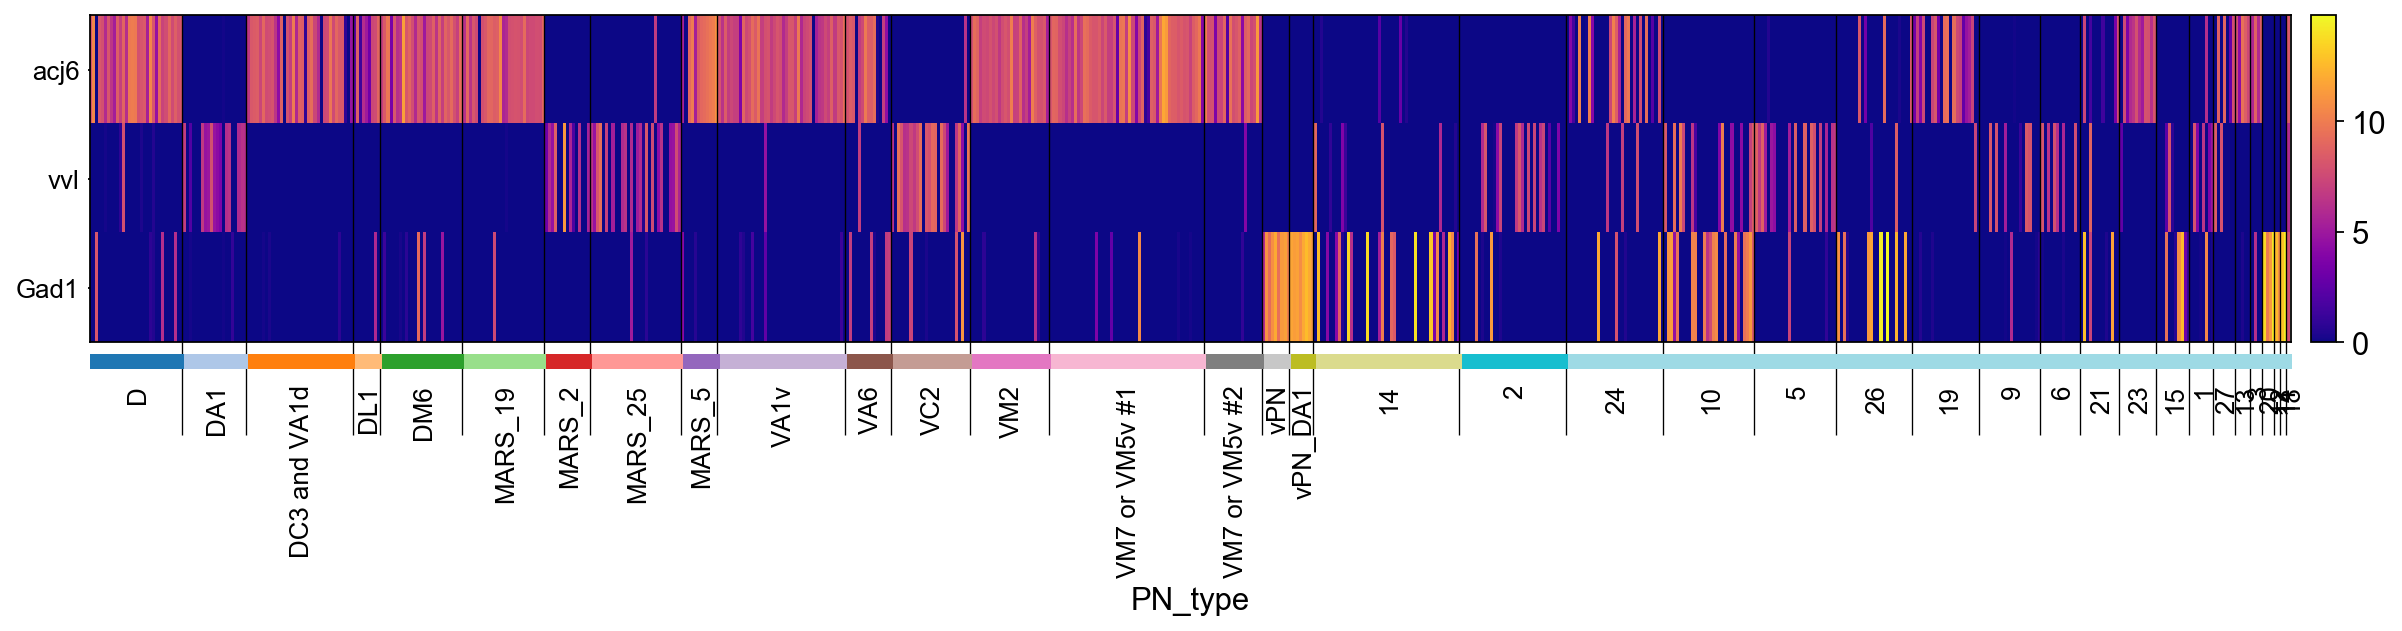

In [13]:
sc.pl.heatmap(adata_adult, var_names=['acj6','vvl','Gad1'], groupby='PN_type', swap_axes=True,
              figsize=(18,3), cmap="plasma")

In [14]:
adPN_type = ["D","DL1","DM6","MARS_19","VA1v","VA6","VM2","VM7 or VM5v #1","VM7 or VM5v #2","DC3 and VA1d",
             "MARS_5","24","19","23"]
lPN_type = ['MARS_2','VC2',"DA1", "MARS_25","2","5","9","6"]

In [15]:
print(len(adPN_type))
print(len(lPN_type))

14
8


In [16]:
adata_adult = adata_adult[adata_adult.obs.PN_type.isin(adPN_type+lPN_type)]

computing PCA
    with n_comps=50
    finished (0:00:00)
    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns["dendrogram_['PN_type']"]`
    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_PN_type']`


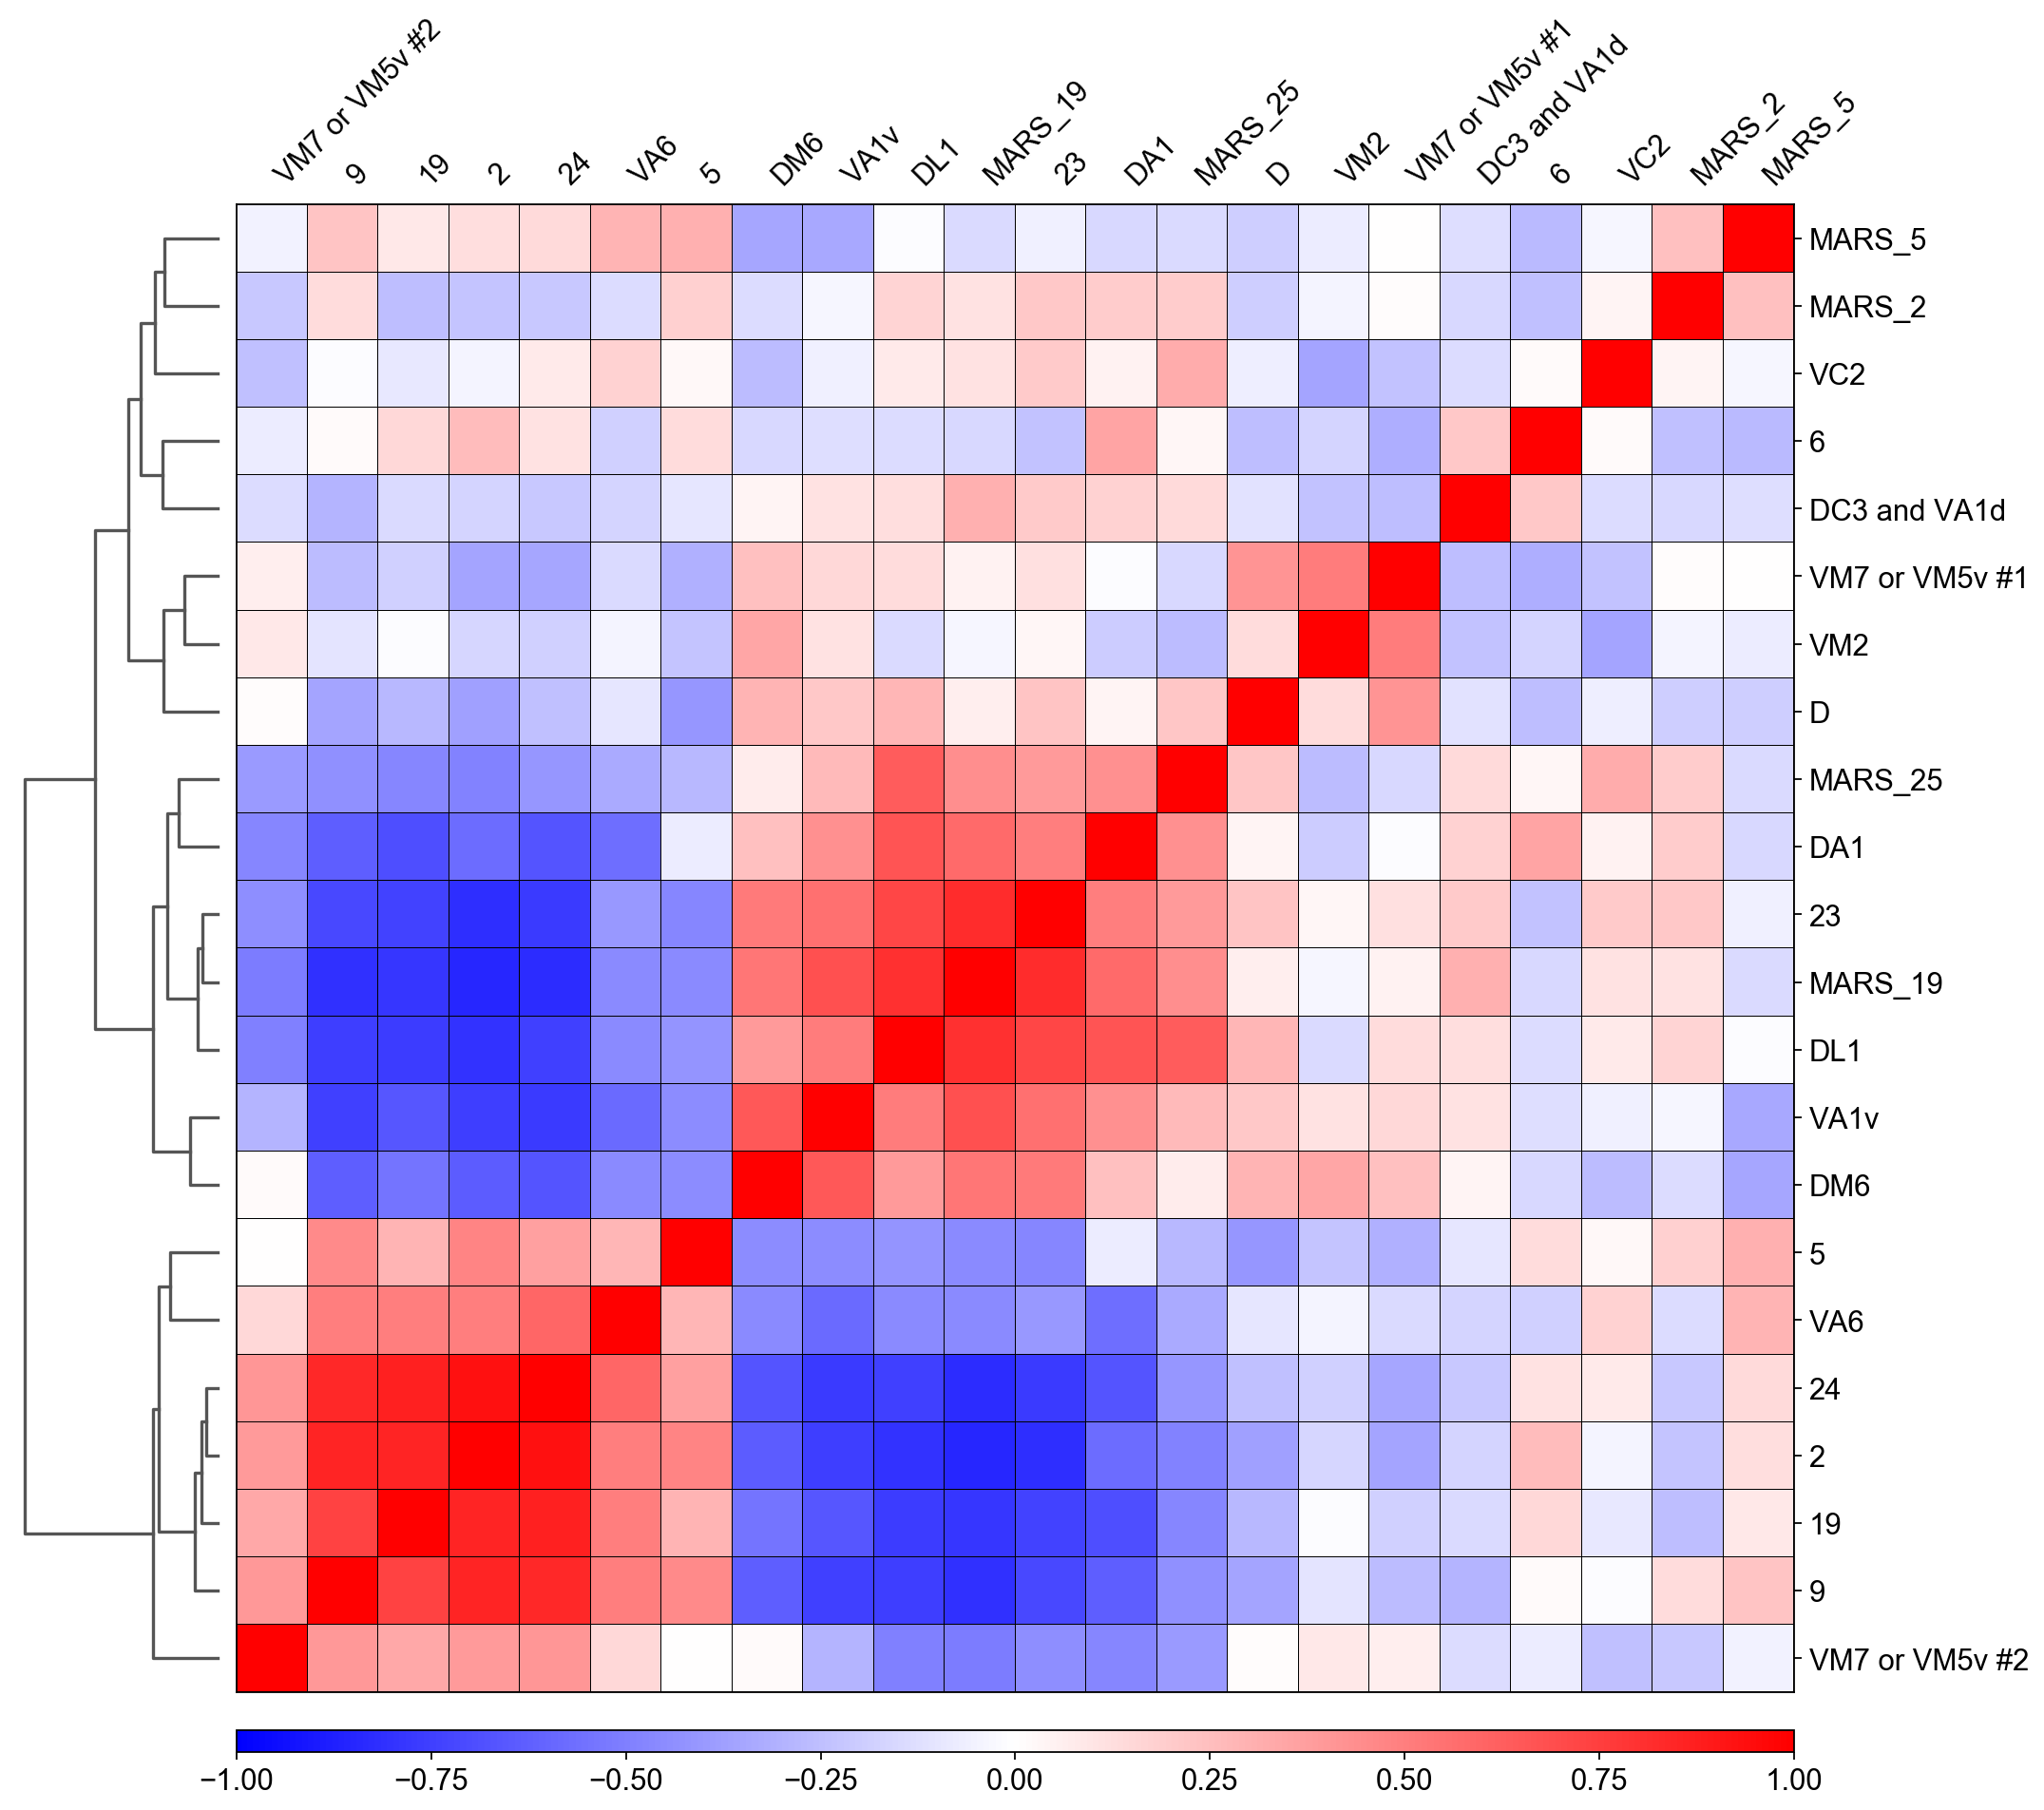

In [17]:
sc.tl.pca(adata_adult, svd_solver='arpack', use_highly_variable=False, random_state=1)
sc.tl.dendrogram(adata_adult, groupby='PN_type',optimal_ordering=True)
sc.pl.correlation_matrix(adata_adult,'PN_type')#, save='_adult_adPN_lPN_pca.pdf')

In [18]:
sc.tl.rank_genes_groups(adata_adult,groupby='PN_type', method='wilcoxon',n_genes=5000)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:02)


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [19]:
pval = pd.DataFrame(adata_adult.uns['rank_genes_groups']['pvals_adj'])

In [20]:
genes = pd.DataFrame(adata_adult.uns['rank_genes_groups']['names'])

In [21]:
all_sig_genes_adult = set()
only_12_adult = set()
for PN_type in genes.columns:
    curr_sig_genes = set(genes[PN_type][pval[PN_type] < 0.01])
    print('number of genes in MARS cluster ',PN_type,' :', len(curr_sig_genes))
    all_sig_genes_adult = all_sig_genes_adult.union(curr_sig_genes)
    if PN_type in PN_type_12:
        only_12_adult = only_12_adult.union(curr_sig_genes)

number of genes in MARS cluster  D  : 17
number of genes in MARS cluster  DA1  : 45
number of genes in MARS cluster  DC3 and VA1d  : 5
number of genes in MARS cluster  DL1  : 3
number of genes in MARS cluster  DM6  : 47
number of genes in MARS cluster  MARS_19  : 259
number of genes in MARS cluster  MARS_2  : 24
number of genes in MARS cluster  MARS_25  : 10
number of genes in MARS cluster  MARS_5  : 13
number of genes in MARS cluster  VA1v  : 121
number of genes in MARS cluster  VA6  : 1
number of genes in MARS cluster  VC2  : 3
number of genes in MARS cluster  VM2  : 7
number of genes in MARS cluster  VM7 or VM5v #1  : 59
number of genes in MARS cluster  VM7 or VM5v #2  : 4
number of genes in MARS cluster  2  : 20
number of genes in MARS cluster  24  : 0
number of genes in MARS cluster  5  : 14
number of genes in MARS cluster  19  : 0
number of genes in MARS cluster  9  : 4
number of genes in MARS cluster  6  : 2
number of genes in MARS cluster  23  : 0


In [22]:
len(all_sig_genes_adult)

542

In [23]:
len(only_12_adult)

227

In [24]:
# write_set_to_file(only_12_adult,"../output/DE_12type/adult_DE.txt")

# 48 h

In [25]:
adata_48h = adata_all[(adata_all.obs['stage'] == '48h') & ((adata_all.obs['PN_type'] != 'vPN') 
                                                           & (adata_all.obs['PN_type'] != 'APL'))]

In [26]:
adata_48h = adata_48h.concatenate(adata_kn_48, index_unique=None)
adata_48h

AnnData object with n_obs × n_vars = 982 × 17474
    obs: 'batch', 'genotype', 'stage', 'n_counts', 'n_genes', 'PN_type', 'MARS', 'HDBSCAN', 'MARS_2way_matched', 'MARS_2way_matched_PN_type', 'lineage', '24h_HDBSCAN', 'matched_type_with_stage', 'mannually_matched'
    var: 'highly_variable-0'
    obsm: 'X_tsne'

In [27]:
adata_48h.obs['PN_type'] = adata_48h.obs['PN_type'].astype('category')

In [28]:
# add MARS label at current stage to replace nan
adata_48h.obs['PN_type'] = adata_48h.obs['PN_type'].cat.add_categories(list(adata_48h[adata_48h.obs['PN_type'] == 'nan'].obs['MARS'].value_counts().index))
selector = adata_48h.obs['PN_type'] == 'nan'
adata_48h.obs.loc[adata_48h.obs.index.isin(selector[selector].index),'PN_type'] = list(adata_48h[adata_48h.obs['PN_type'] == 'nan'].obs['MARS'])

adata_48h.obs['PN_type'] = adata_48h.obs['PN_type'].cat.add_categories(list(adata_48h[adata_48h.obs['PN_type'] == ''].obs['MARS'].value_counts().index))
selector = adata_48h.obs['PN_type'] == ''
adata_48h.obs.loc[adata_48h.obs.index.isin(selector[selector].index),'PN_type'] = list(adata_48h[adata_48h.obs['PN_type'] == ''].obs['MARS'])

... storing 'genotype' as categorical
... storing 'MARS' as categorical
... storing 'HDBSCAN' as categorical
... storing 'MARS_2way_matched' as categorical
... storing 'MARS_2way_matched_PN_type' as categorical
... storing 'lineage' as categorical
... storing '24h_HDBSCAN' as categorical
... storing 'matched_type_with_stage' as categorical
... storing 'mannually_matched' as categorical


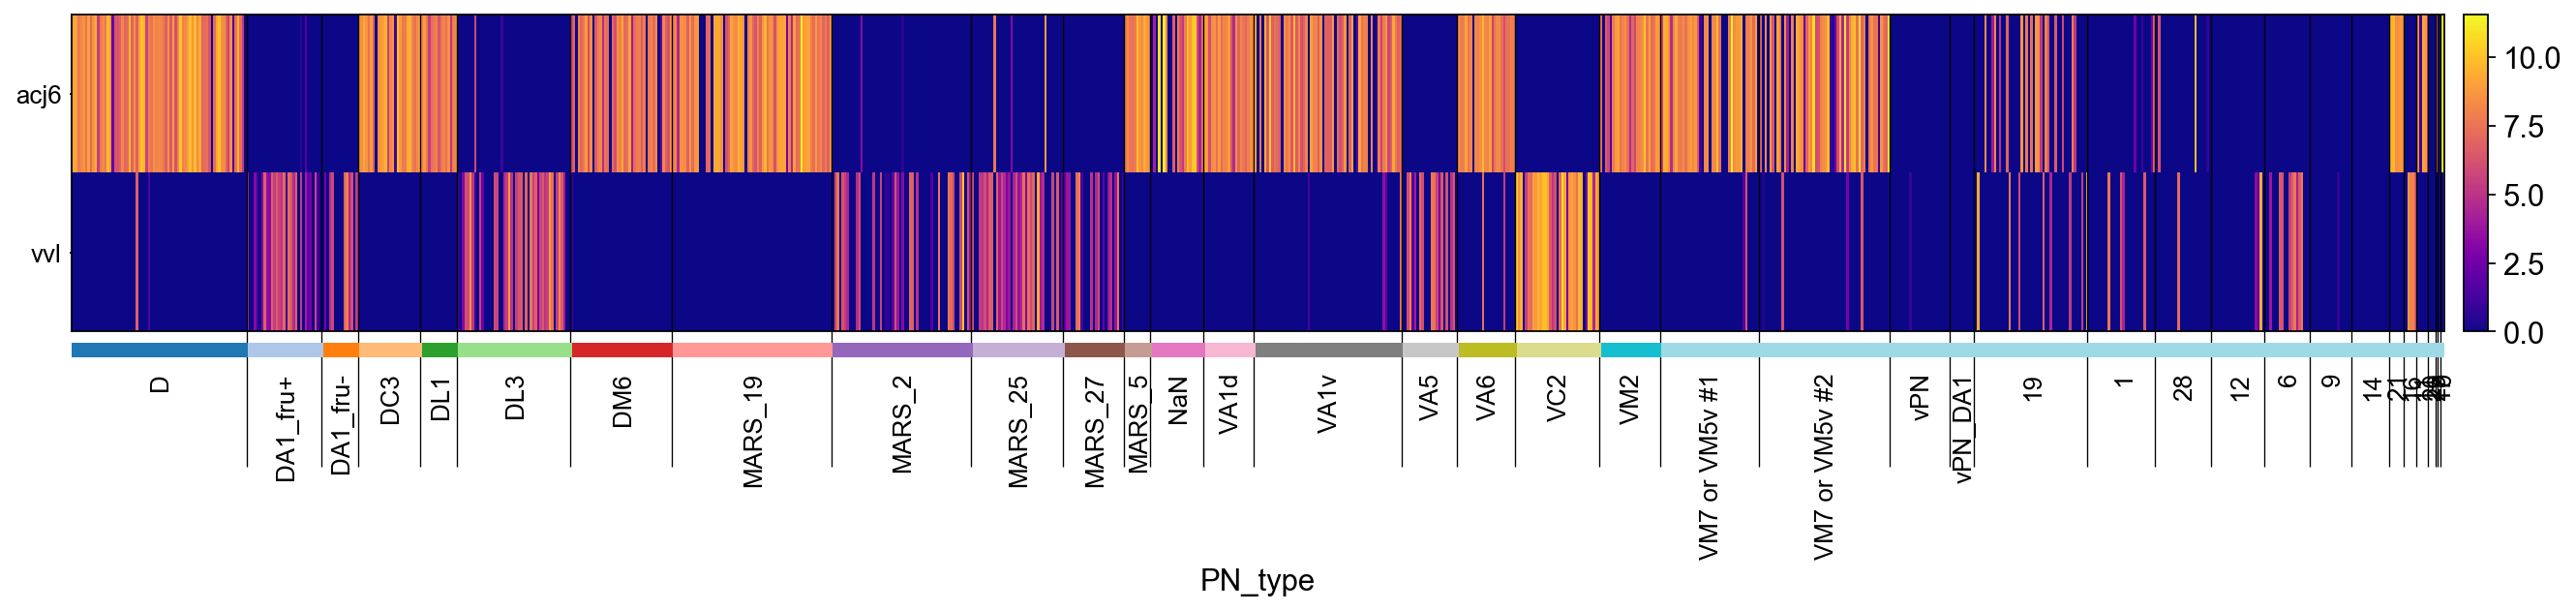

In [29]:
sc.pl.heatmap(adata_48h, var_names=['acj6','vvl'], groupby='PN_type', swap_axes=True,
              figsize=(20,3), cmap="plasma")

In [30]:
adPN_type = ["D","DC3","DL1","DM6","MARS_19","MARS_5","VA1d","VA1v","VA6","VM2","VM7 or VM5v #1",
             "VM7 or VM5v #2","21","11","20"]
lPN_type = ["16","DA1_fru+","DA1_fru-","DL3","MARS_2","MARS_25","MARS_27","VA5",'VC2',"6"]

In [31]:
adata_48h = adata_48h[adata_48h.obs.PN_type.isin(adPN_type+lPN_type)]

computing PCA
    with n_comps=50
    finished (0:00:00)
    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns["dendrogram_['PN_type']"]`
    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_PN_type']`


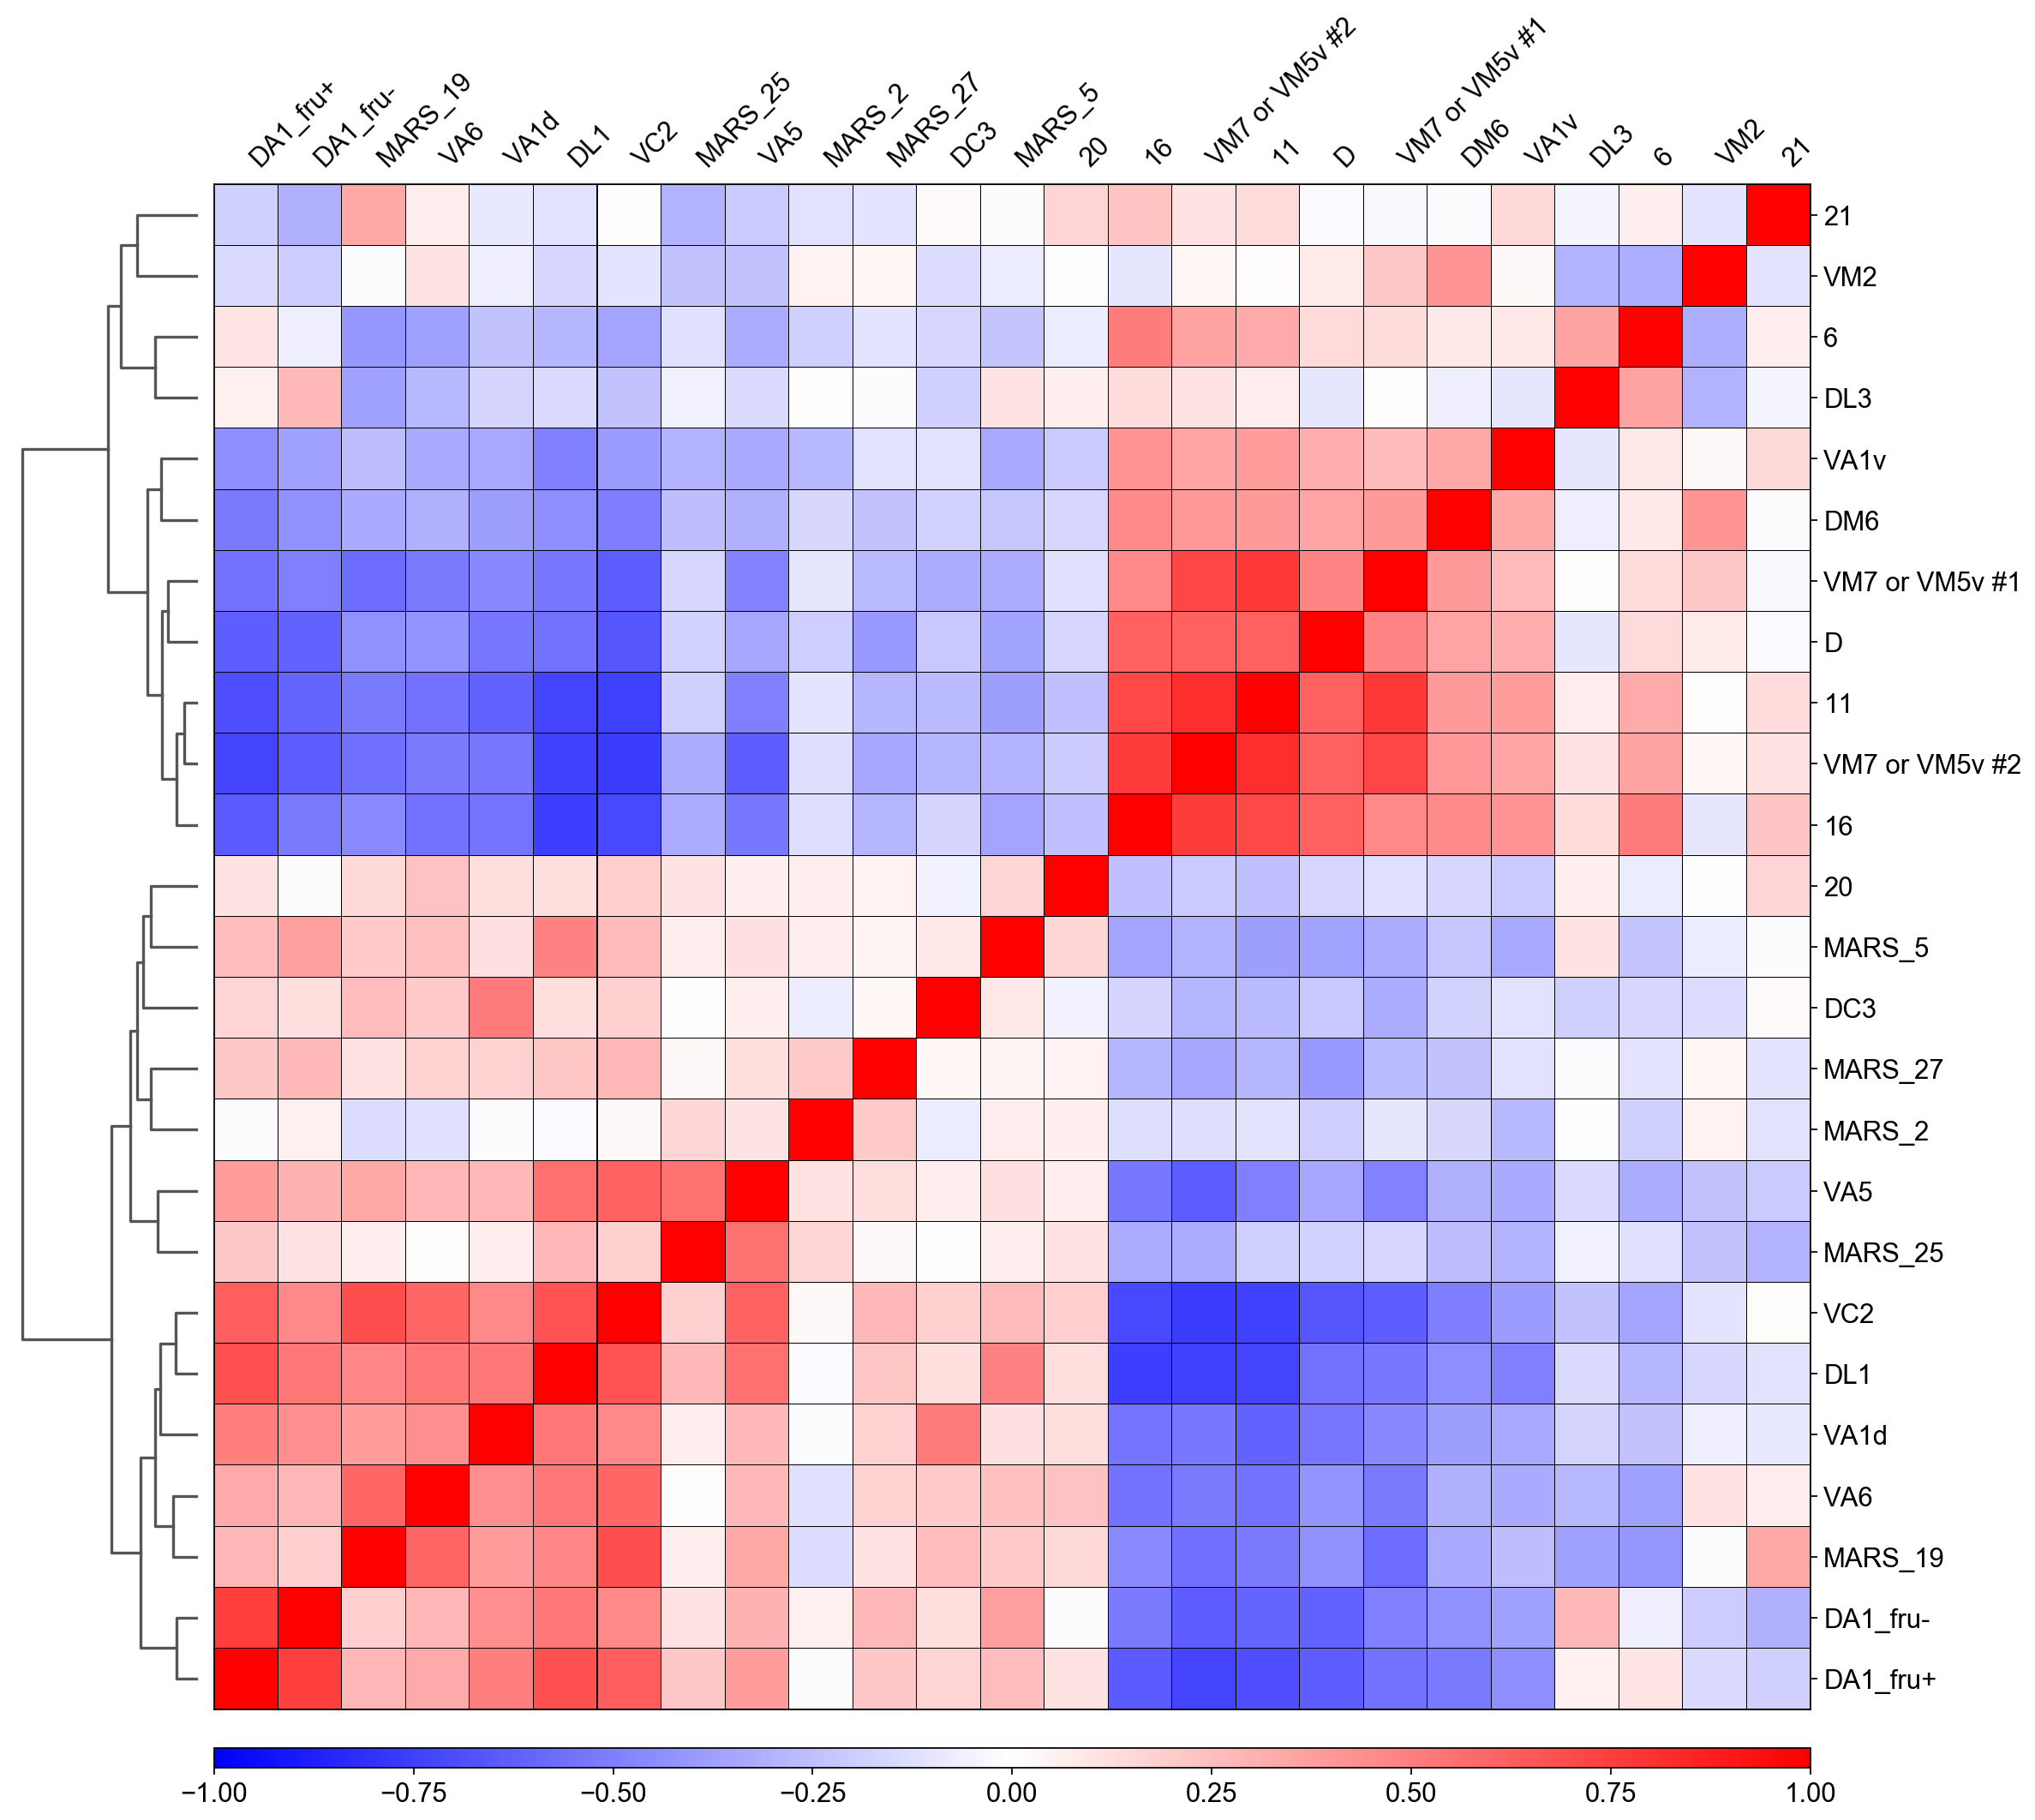

In [32]:
sc.tl.pca(adata_48h, svd_solver='arpack', use_highly_variable=False, random_state=1)
sc.tl.dendrogram(adata_48h, groupby='PN_type',optimal_ordering=True)
sc.pl.correlation_matrix(adata_48h,'PN_type')#, save='_48h_adPN_lPN_pca.pdf')

In [33]:
sc.tl.rank_genes_groups(adata_48h,groupby='PN_type', method='wilcoxon',n_genes=5000)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:03)


In [34]:
pval = pd.DataFrame(adata_48h.uns['rank_genes_groups']['pvals_adj'])

In [35]:
genes = pd.DataFrame(adata_48h.uns['rank_genes_groups']['names'])

In [36]:
all_sig_genes_48h = set()
only_12_48h = set()
for PN_type in genes.columns:
    curr_sig_genes = set(genes[PN_type][pval[PN_type] < 0.01])
    all_sig_genes_48h = all_sig_genes_48h.union(curr_sig_genes)
    print('number of genes in MARS cluster ',PN_type,' :', len(curr_sig_genes))
    if PN_type in PN_type_12:
        only_12_48h = only_12_48h.union(curr_sig_genes)

number of genes in MARS cluster  D  : 60
number of genes in MARS cluster  DA1_fru+  : 175
number of genes in MARS cluster  DA1_fru-  : 55
number of genes in MARS cluster  DC3  : 36
number of genes in MARS cluster  DL1  : 32
number of genes in MARS cluster  DL3  : 100
number of genes in MARS cluster  DM6  : 22
number of genes in MARS cluster  MARS_19  : 36
number of genes in MARS cluster  MARS_2  : 106
number of genes in MARS cluster  MARS_25  : 32
number of genes in MARS cluster  MARS_27  : 22
number of genes in MARS cluster  MARS_5  : 15
number of genes in MARS cluster  VA1d  : 18
number of genes in MARS cluster  VA1v  : 50
number of genes in MARS cluster  VA5  : 23
number of genes in MARS cluster  VA6  : 44
number of genes in MARS cluster  VC2  : 39
number of genes in MARS cluster  VM2  : 13
number of genes in MARS cluster  VM7 or VM5v #1  : 21
number of genes in MARS cluster  VM7 or VM5v #2  : 32
number of genes in MARS cluster  6  : 5
number of genes in MARS cluster  21  : 0
number

In [37]:
len(only_12_48h)

415

In [38]:
# write_set_to_file(only_12_48h,"../output/DE_12type/48h_DE.txt")

# 24h

In [39]:
adata_24h = adata_all[(adata_all.obs['stage'] == '24h') & 
                        ((adata_all.obs['PN_type'] != 'vPN') & (adata_all.obs['PN_type'] != 'APL'))]

In [40]:
adata_24h.obs['PN_type'] = adata_24h.obs['PN_type'].astype('category')

Trying to set attribute `.obs` of view, copying.


In [41]:
# add MARS label at current stage to replace nan
adata_24h.obs['PN_type'] = adata_24h.obs['PN_type'].cat.add_categories(list(adata_24h[adata_24h.obs['PN_type'] == 'nan'].obs['MARS'].value_counts().index))
selector = adata_24h.obs['PN_type'] == 'nan'
adata_24h.obs.loc[adata_24h.obs.index.isin(selector[selector].index),'PN_type'] = list(adata_24h[adata_24h.obs['PN_type'] == 'nan'].obs['MARS'])

adata_24h.obs['PN_type'] = adata_24h.obs['PN_type'].cat.add_categories(list(adata_24h[adata_24h.obs['PN_type'] == ''].obs['MARS'].value_counts().index))
selector = adata_24h.obs['PN_type'] == ''
adata_24h.obs.loc[adata_24h.obs.index.isin(selector[selector].index),'PN_type'] = list(adata_24h[adata_24h.obs['PN_type'] == ''].obs['MARS'])

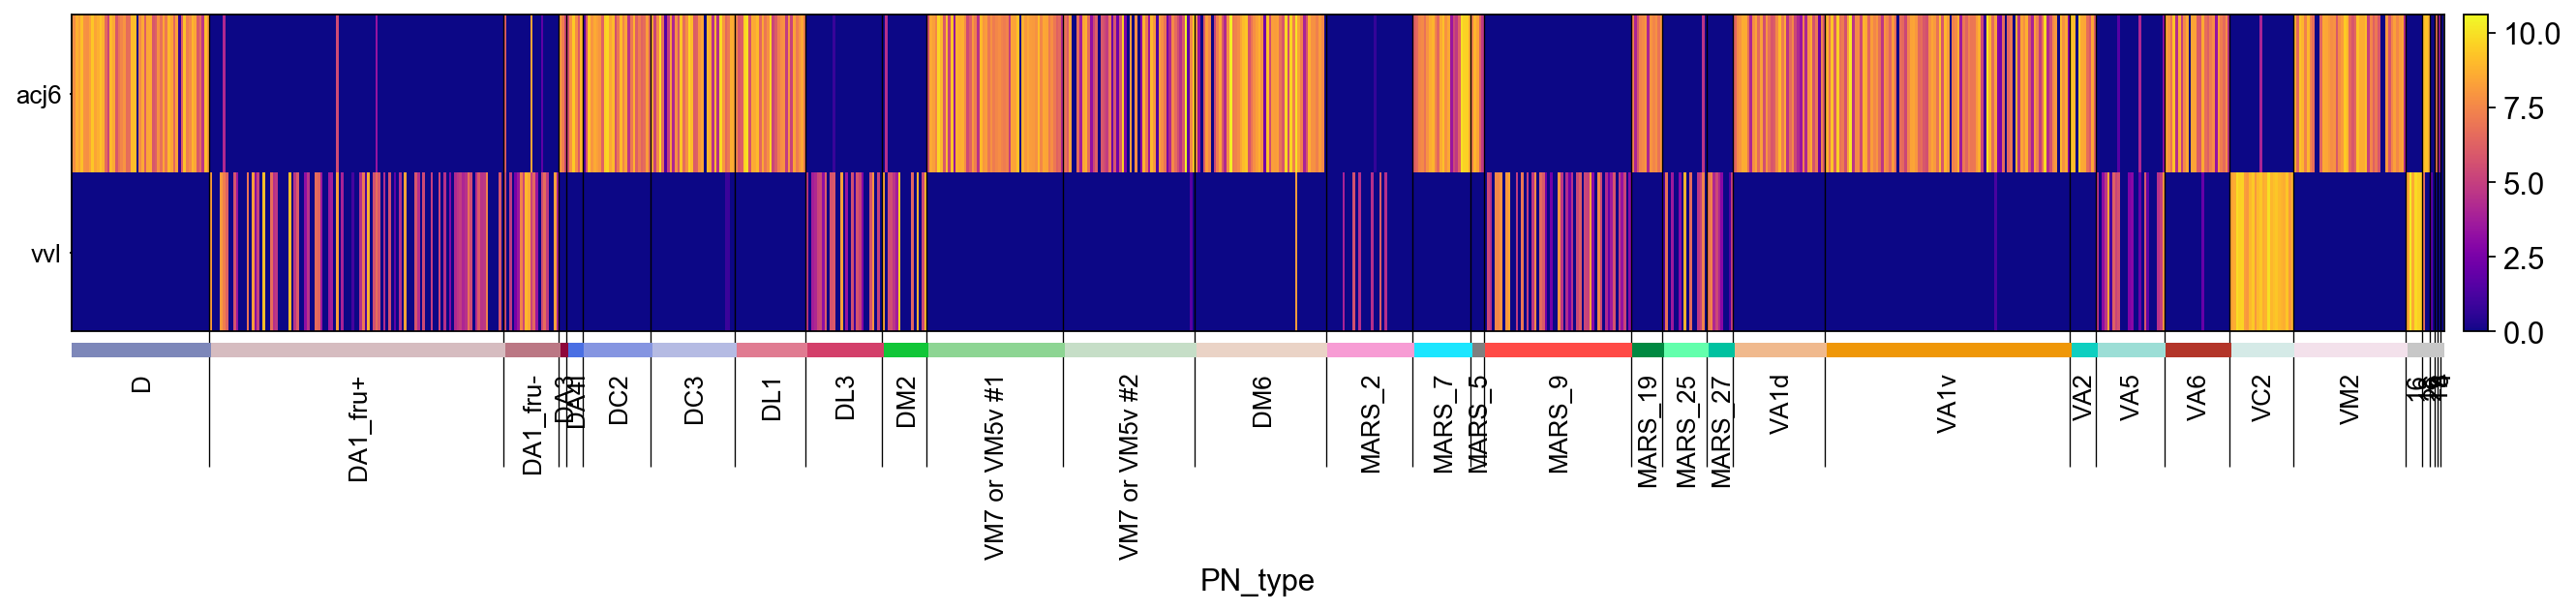

In [42]:
sc.pl.heatmap(adata_24h, var_names=['acj6','vvl'], groupby='PN_type', swap_axes=True,
              figsize=(20,3), cmap="plasma")

In [43]:
adPN_type = ["D","DC2","DC3","DL1","VM7 or VM5v #1","VM7 or VM5v #2","DM6","MARS_7","MARS_5","MARS_19",
             "VA1d","VA1v","VA6","VM2","DA4l",'VA2']
lPN_type = ["DA1_fru+","DA1_fru-","DL3","DM2","MARS_2","MARS_9","MARS_25","MARS_27",
            "VA5",'VC2',"16"]

In [44]:
adata_24h = adata_24h[adata_24h.obs.PN_type.isin(adPN_type+lPN_type)]

computing PCA
    with n_comps=50
    finished (0:00:01)
    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns["dendrogram_['PN_type']"]`
    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_PN_type']`


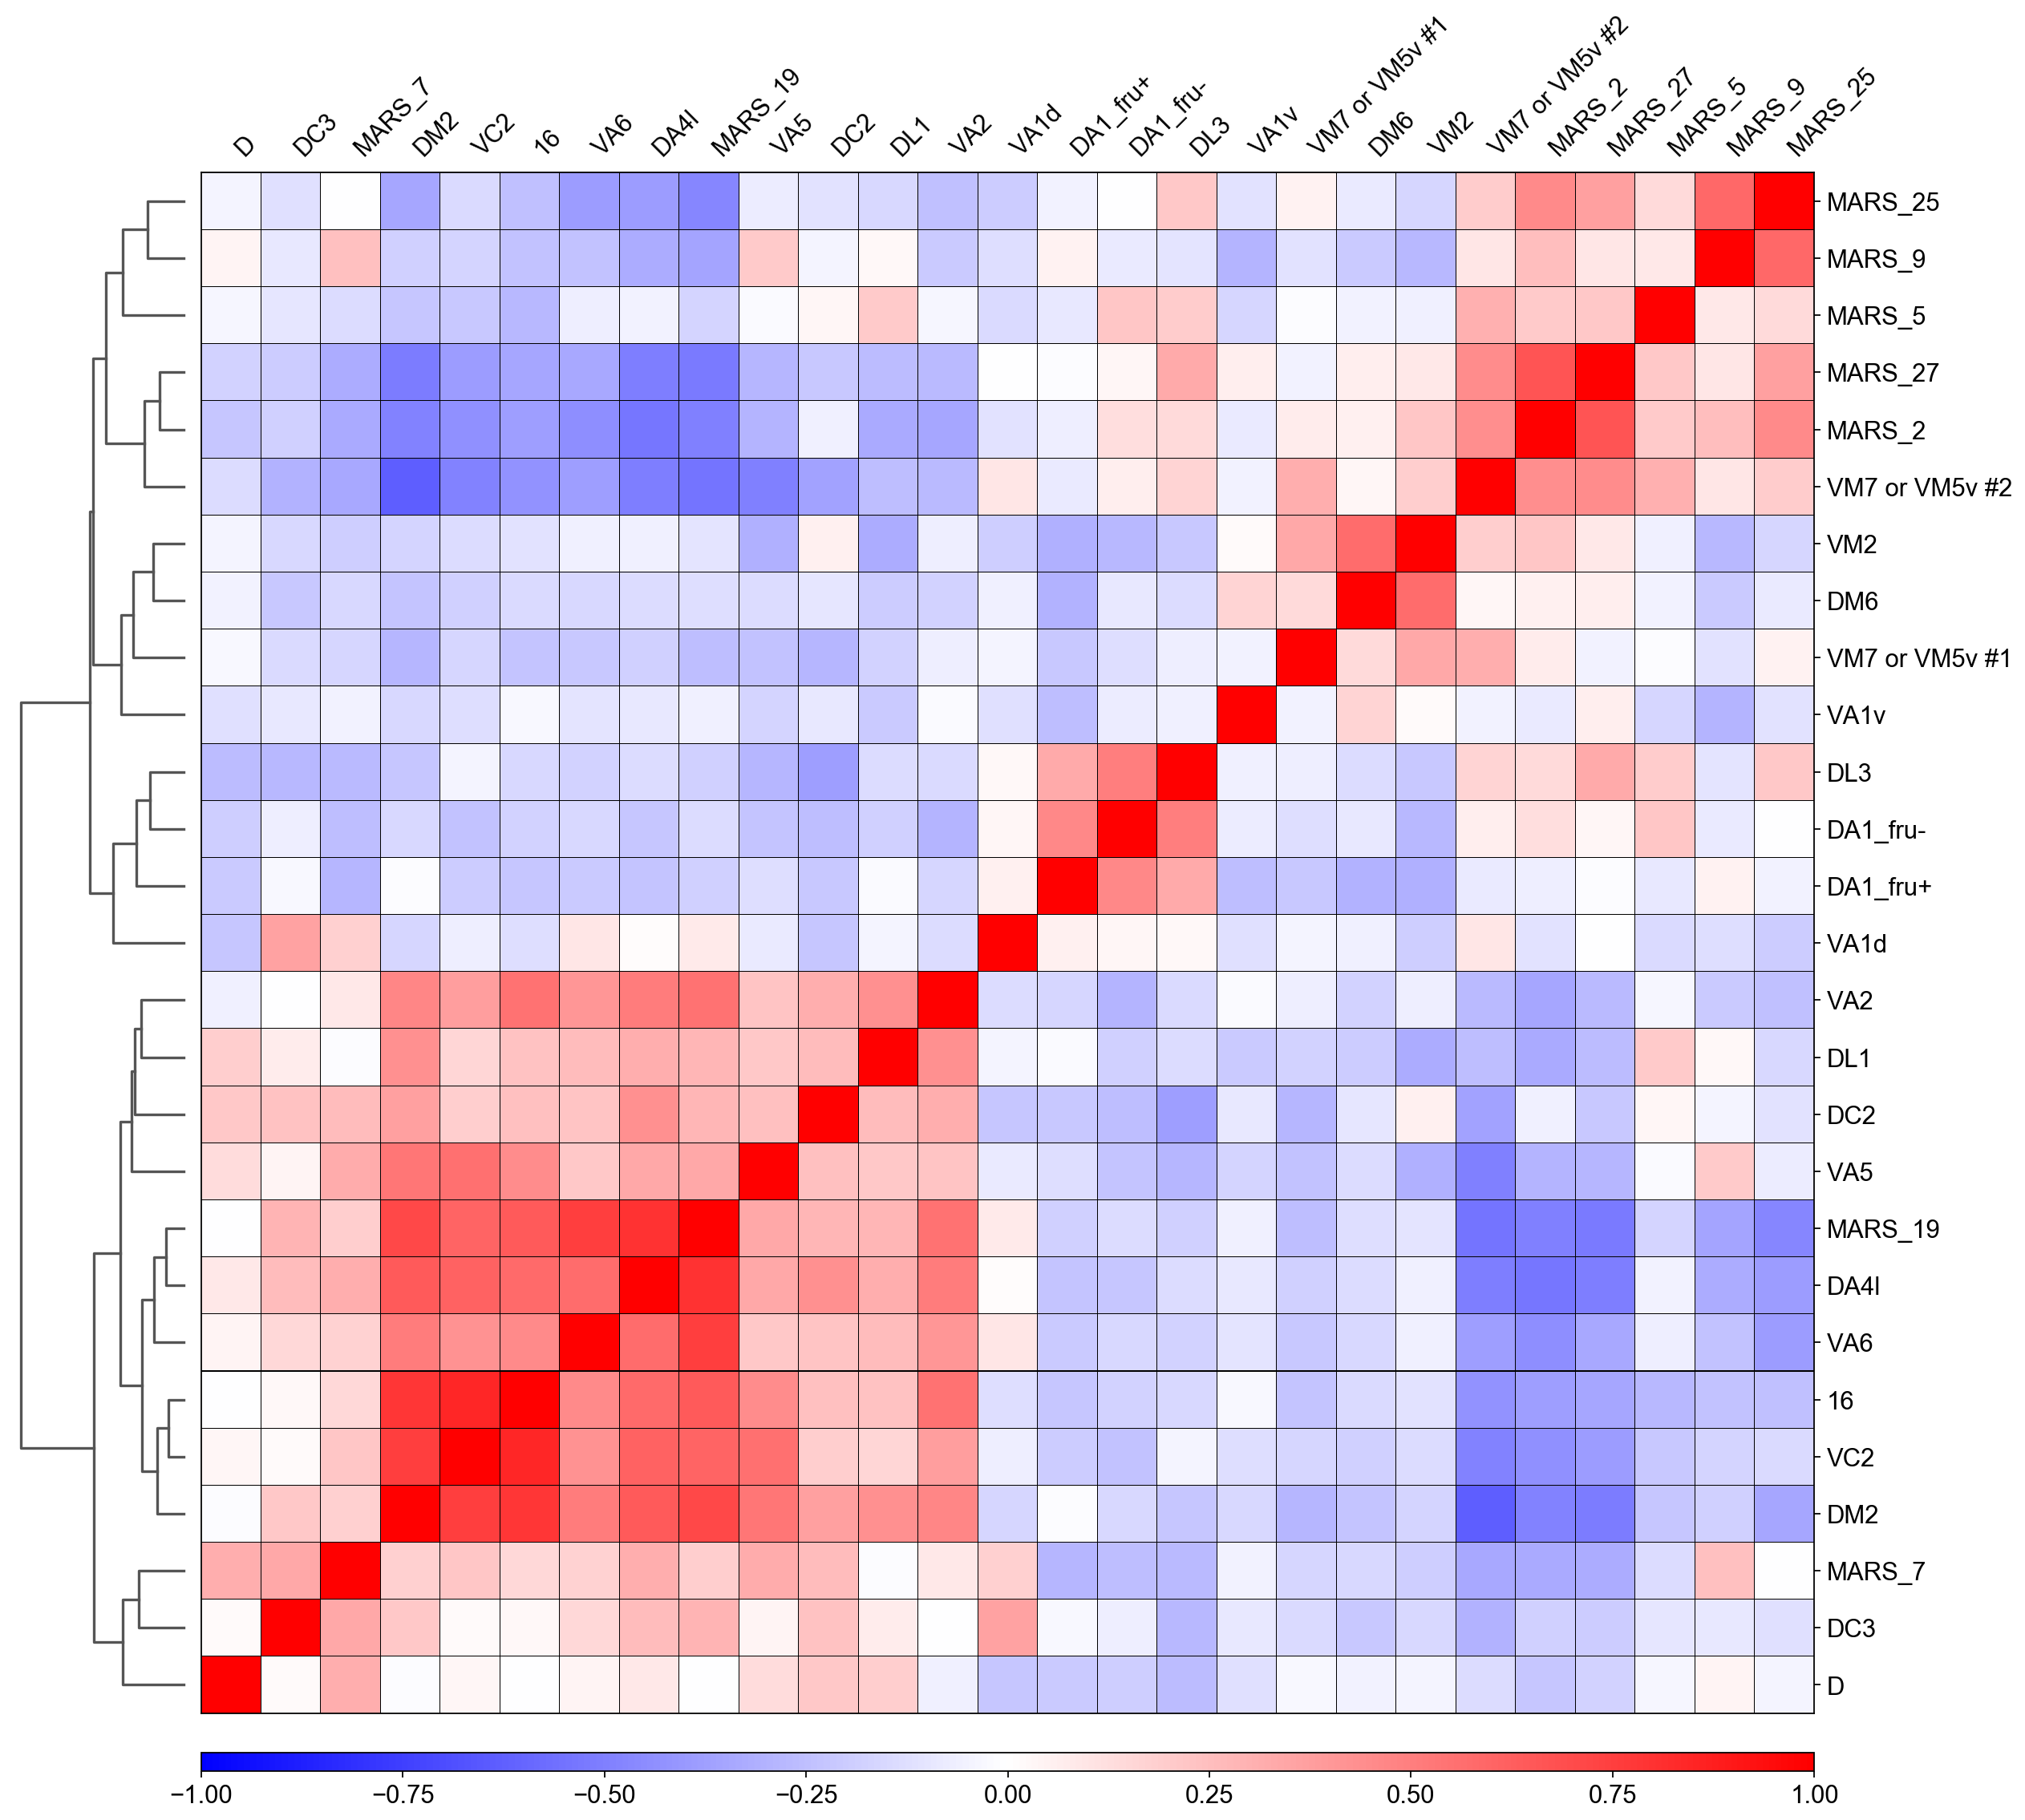

In [45]:
sc.tl.pca(adata_24h, svd_solver='arpack', use_highly_variable=False, random_state=1)
sc.tl.dendrogram(adata_24h, groupby='PN_type',optimal_ordering=True)
sc.pl.correlation_matrix(adata_24h,'PN_type')#, save='_24h_adPN_lPN_pca.pdf')

In [46]:
sc.tl.rank_genes_groups(adata_24h,groupby='PN_type', method='wilcoxon',n_genes=5000)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:04)


In [47]:
pval = pd.DataFrame(adata_24h.uns['rank_genes_groups']['pvals_adj'])

In [48]:
genes = pd.DataFrame(adata_24h.uns['rank_genes_groups']['names'])

In [49]:
sc.tl.rank_genes_groups(adata_24h,groupby='PN_type', method='wilcoxon',n_genes=5000)
pval = pd.DataFrame(adata_24h.uns['rank_genes_groups']['pvals_adj'])
genes = pd.DataFrame(adata_24h.uns['rank_genes_groups']['names'])

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:04)


In [50]:
all_sig_genes = set()
only_12_24h = set()
for MARS in genes.columns:
    curr_sig_genes = set(genes[MARS][pval[MARS] < 0.01])
    print('number of genes in MARS cluster ',MARS,' :', len(curr_sig_genes))
    all_sig_genes = all_sig_genes.union(curr_sig_genes)
    if MARS in PN_type_12:
        only_12_24h = only_12_24h.union(curr_sig_genes)

number of genes in MARS cluster  D  : 79
number of genes in MARS cluster  DA1_fru+  : 90
number of genes in MARS cluster  DA1_fru-  : 24
number of genes in MARS cluster  DA4l  : 0
number of genes in MARS cluster  DC2  : 24
number of genes in MARS cluster  DC3  : 28
number of genes in MARS cluster  DL1  : 39
number of genes in MARS cluster  DL3  : 31
number of genes in MARS cluster  DM2  : 20
number of genes in MARS cluster  VM7 or VM5v #1  : 50
number of genes in MARS cluster  VM7 or VM5v #2  : 44
number of genes in MARS cluster  DM6  : 65
number of genes in MARS cluster  MARS_2  : 35
number of genes in MARS cluster  MARS_7  : 17
number of genes in MARS cluster  MARS_5  : 0
number of genes in MARS cluster  MARS_9  : 70
number of genes in MARS cluster  MARS_19  : 13
number of genes in MARS cluster  MARS_25  : 3
number of genes in MARS cluster  MARS_27  : 0
number of genes in MARS cluster  VA1d  : 51
number of genes in MARS cluster  VA1v  : 101
number of genes in MARS cluster  VA2  : 0
n

In [51]:
len(only_12_24h)

419

In [52]:
len(all_sig_genes)

497

In [53]:
# write_set_to_file(only_12_24h,"../output/DE_12type/24h_DE.txt")

# 0h

In [54]:
adata_0h = adata_all[(adata_all.obs['stage'] == '0h') & 
                        ((adata_all.obs['PN_type'] != 'vPN') & (adata_all.obs['PN_type'] != 'APL'))]

In [55]:
adata_0h.obs['PN_type'] = adata_0h.obs['PN_type'].astype('category')

Trying to set attribute `.obs` of view, copying.


In [56]:
# add MARS label at current stage to replace nan
adata_0h.obs['PN_type'] = adata_0h.obs['PN_type'].cat.add_categories(list(adata_0h[adata_0h.obs['PN_type'] == 'nan'].obs['MARS'].value_counts().index))
selector = adata_0h.obs['PN_type'] == 'nan'
adata_0h.obs.loc[adata_0h.obs.index.isin(selector[selector].index),'PN_type'] = list(adata_0h[adata_0h.obs['PN_type'] == 'nan'].obs['MARS'])

adata_0h.obs['PN_type'] = adata_0h.obs['PN_type'].cat.add_categories(list(adata_0h[adata_0h.obs['PN_type'] == ''].obs['MARS'].value_counts().index))
selector = adata_0h.obs['PN_type'] == ''
adata_0h.obs.loc[adata_0h.obs.index.isin(selector[selector].index),'PN_type'] = list(adata_0h[adata_0h.obs['PN_type'] == ''].obs['MARS'])

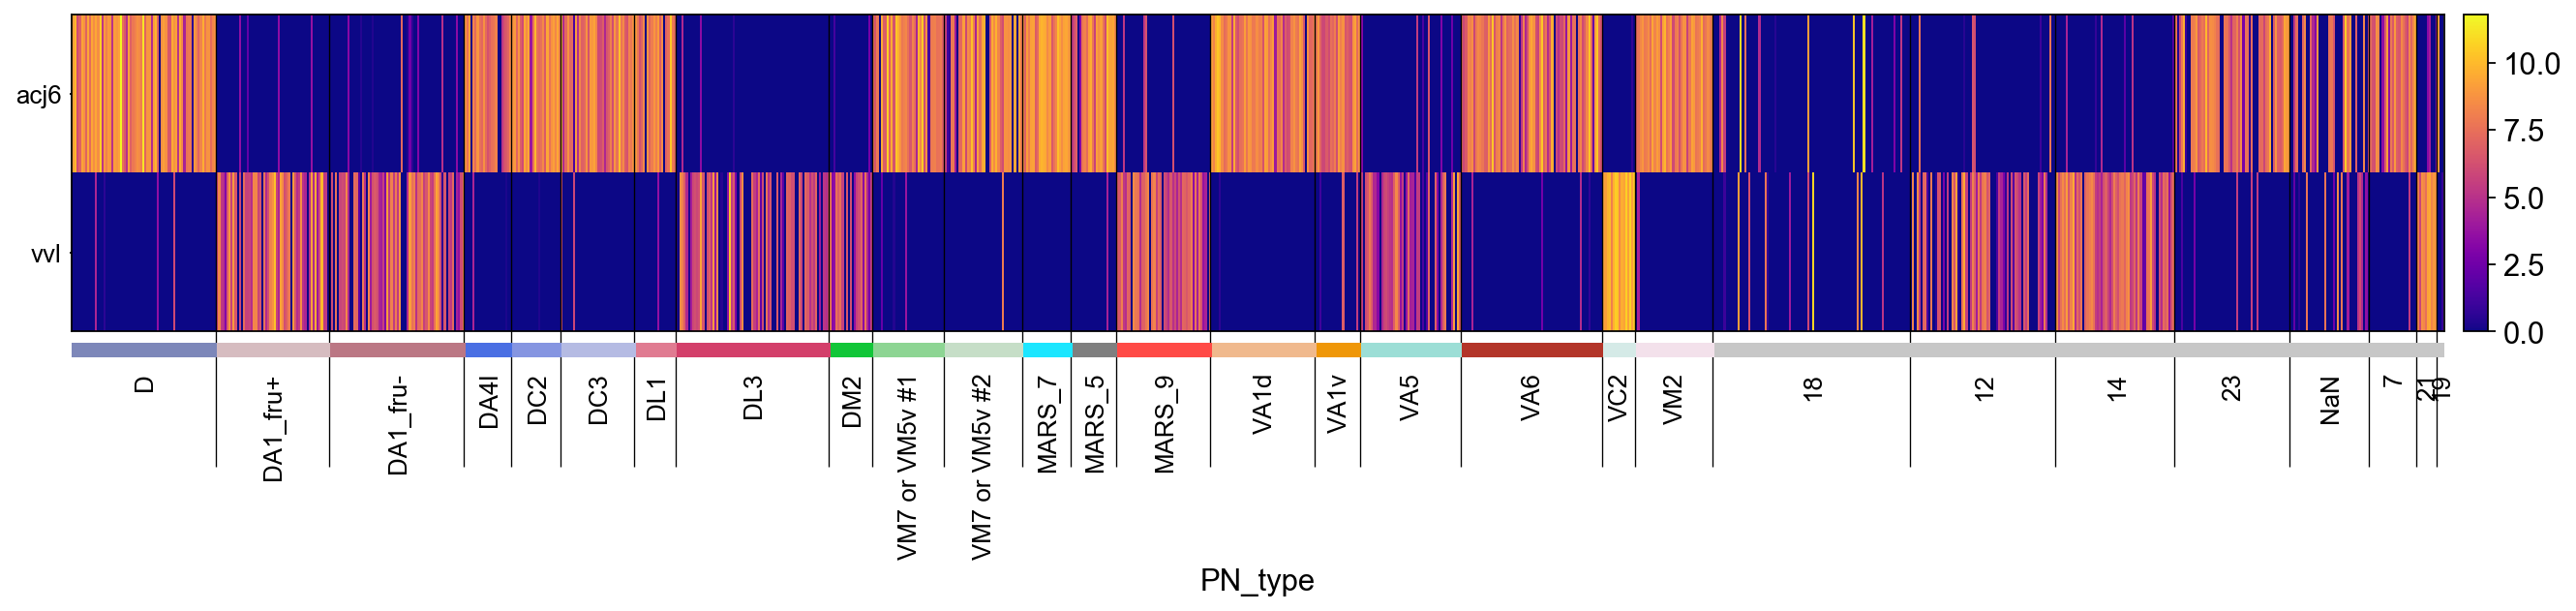

In [57]:
sc.pl.heatmap(adata_0h, var_names=['acj6','vvl'], groupby='PN_type', swap_axes=True,
              figsize=(20,3), cmap="plasma")

In [58]:
adata_0h = adata_0h[~adata_0h.obs.PN_type.isin(["18","NaN","19"])]

computing PCA
    with n_comps=50
    finished (0:00:01)
    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns["dendrogram_['PN_type']"]`
    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_PN_type']`


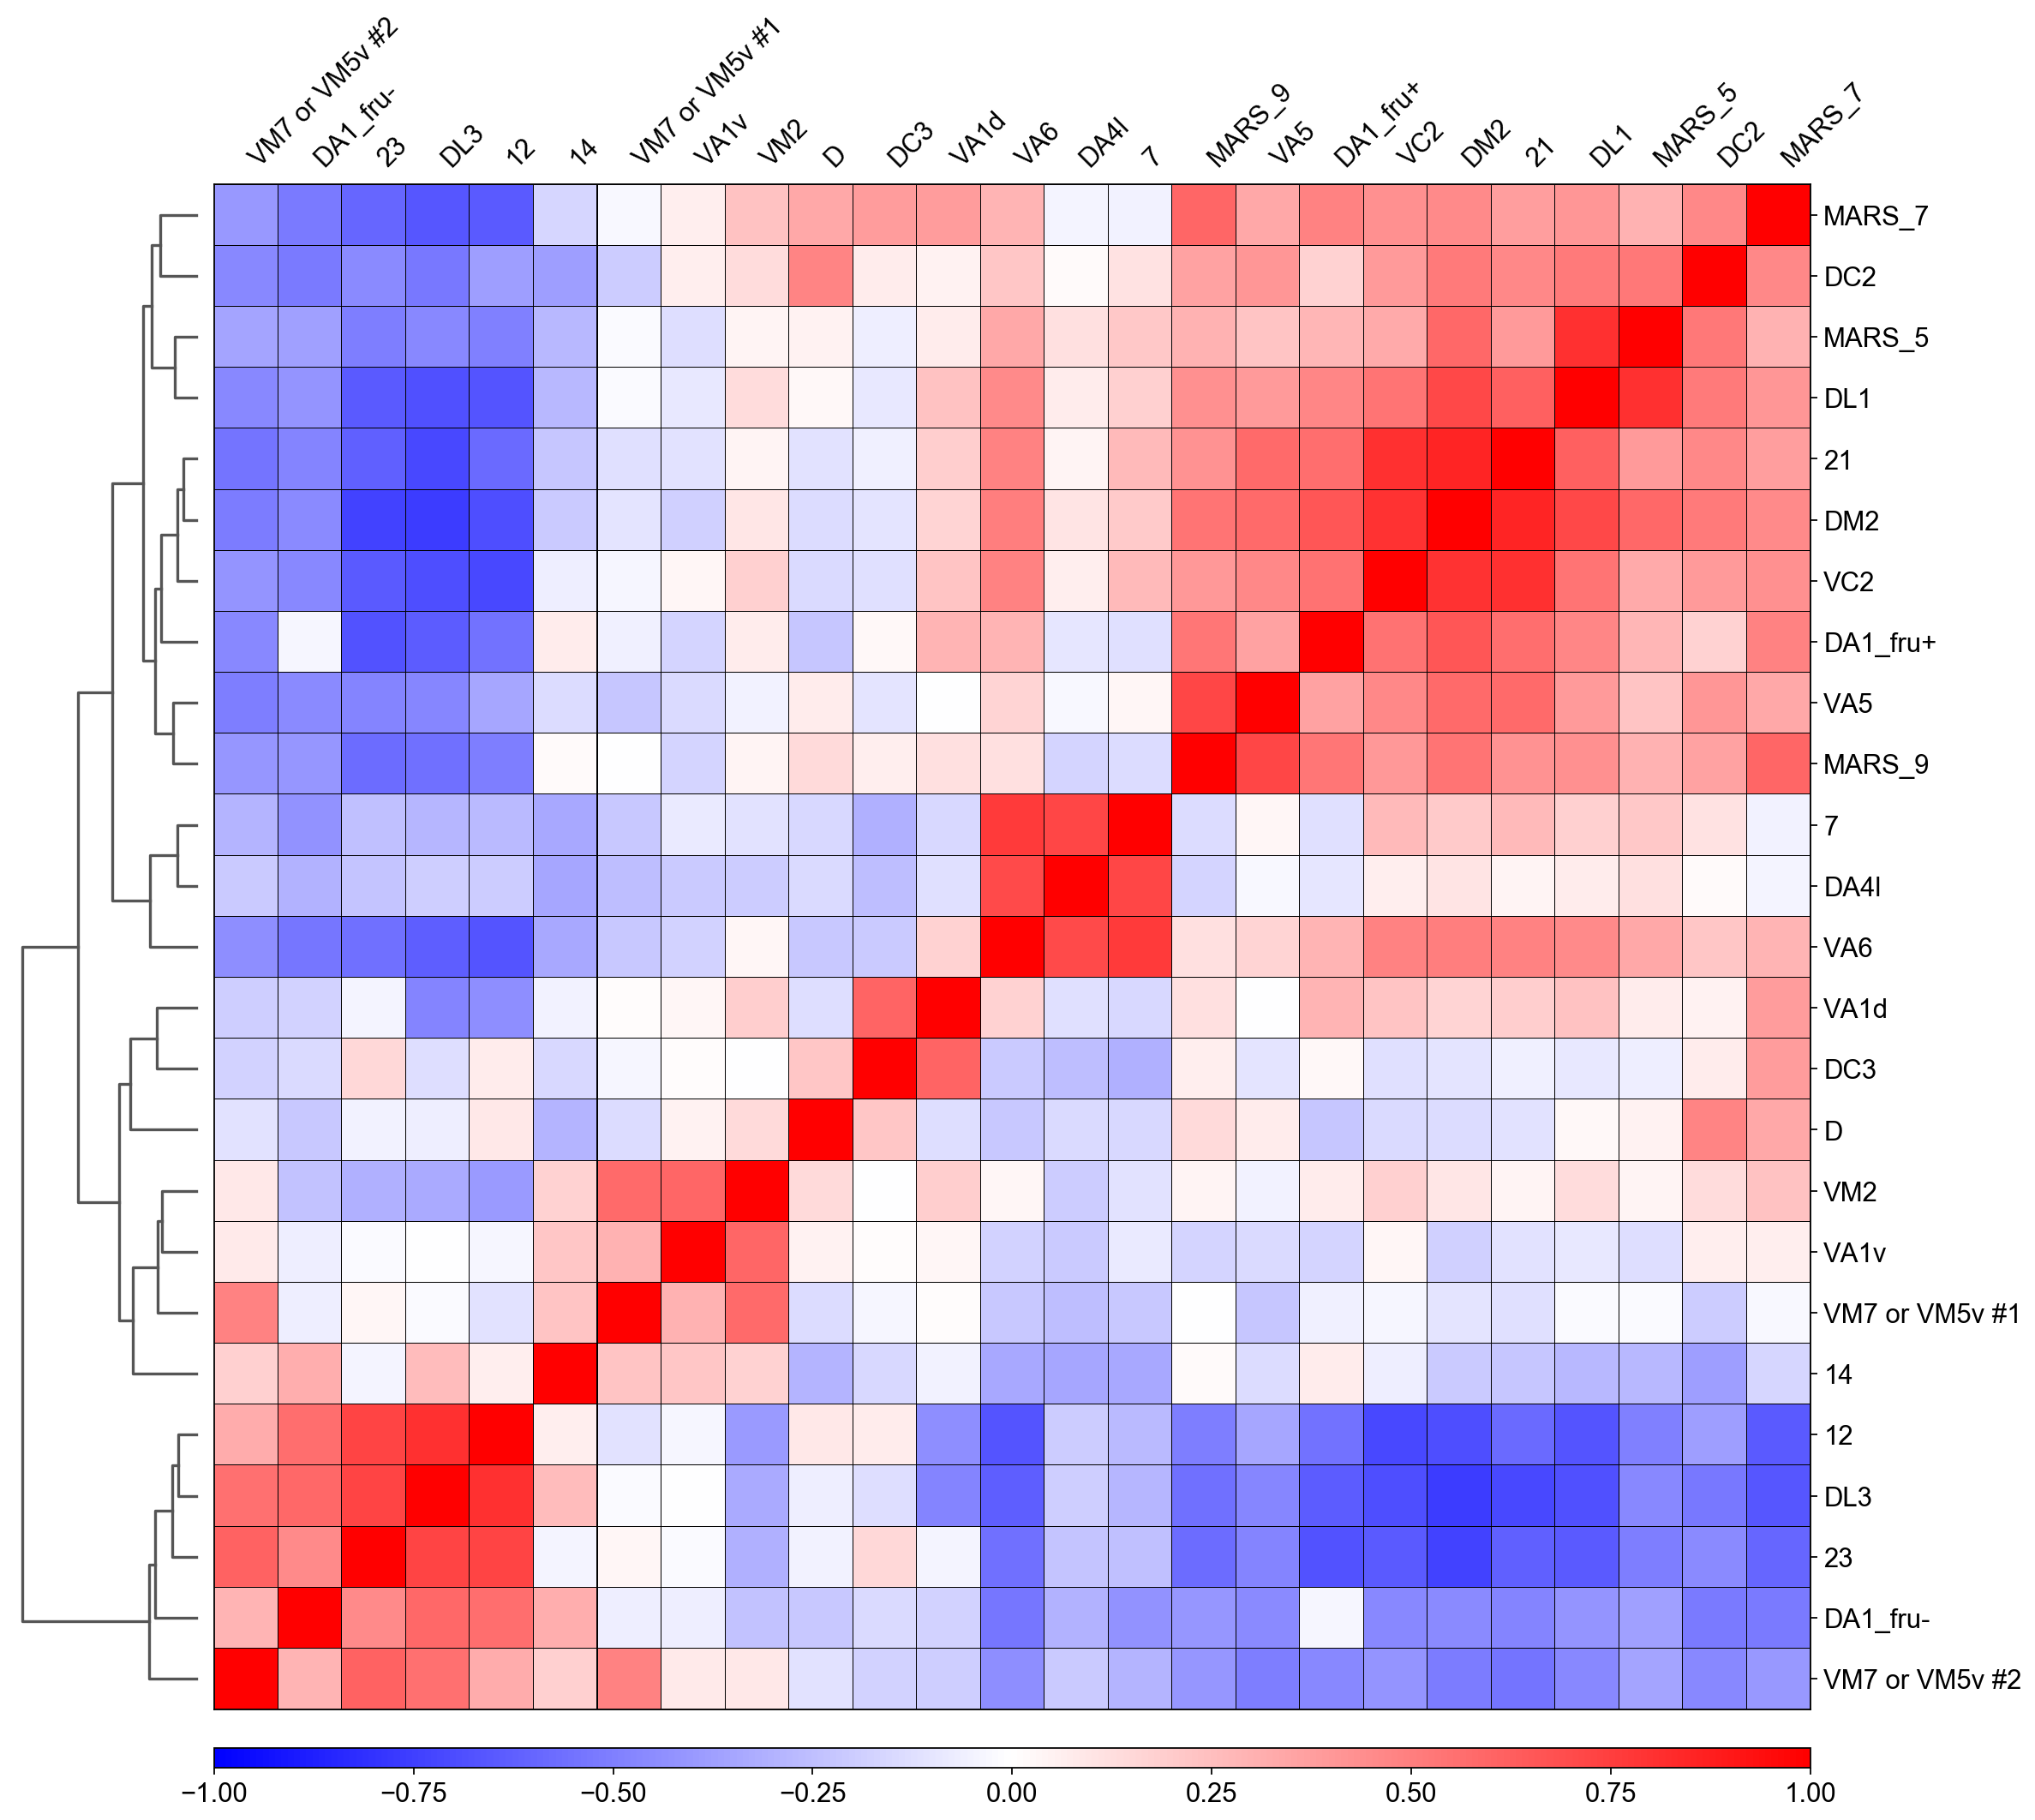

In [59]:
sc.tl.pca(adata_0h, svd_solver='arpack', use_highly_variable=False, random_state=1)
sc.tl.dendrogram(adata_0h, groupby='PN_type',optimal_ordering=True)
sc.pl.correlation_matrix(adata_0h,'PN_type')#, save='_0h_adPN_lPN_pca.pdf')

In [60]:
sc.tl.rank_genes_groups(adata_0h,groupby='PN_type', method='wilcoxon',n_genes=5000)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:04)


In [61]:
pval = pd.DataFrame(adata_0h.uns['rank_genes_groups']['pvals_adj'])

In [62]:
genes = pd.DataFrame(adata_0h.uns['rank_genes_groups']['names'])

In [63]:
sc.tl.rank_genes_groups(adata_0h,groupby='PN_type', method='wilcoxon',n_genes=5000)
pval = pd.DataFrame(adata_0h.uns['rank_genes_groups']['pvals_adj'])
genes = pd.DataFrame(adata_0h.uns['rank_genes_groups']['names'])

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:04)


In [64]:
all_sig_genes_0h = set()
only_12_0h = set()
for MARS in genes.columns:
    curr_sig_genes = set(genes[MARS][pval[MARS] < 0.01])
    print('number of genes in MARS cluster ',MARS,' :', len(curr_sig_genes))
    all_sig_genes_0h = all_sig_genes_0h.union(curr_sig_genes)
    if MARS in PN_type_12:
        only_12_0h = only_12_0h.union(curr_sig_genes)

number of genes in MARS cluster  D  : 45
number of genes in MARS cluster  DA1_fru+  : 38
number of genes in MARS cluster  DA1_fru-  : 50
number of genes in MARS cluster  DA4l  : 130
number of genes in MARS cluster  DC2  : 26
number of genes in MARS cluster  DC3  : 17
number of genes in MARS cluster  DL1  : 29
number of genes in MARS cluster  DL3  : 38
number of genes in MARS cluster  DM2  : 38
number of genes in MARS cluster  VM7 or VM5v #1  : 34
number of genes in MARS cluster  VM7 or VM5v #2  : 26
number of genes in MARS cluster  MARS_7  : 23
number of genes in MARS cluster  MARS_5  : 35
number of genes in MARS cluster  MARS_9  : 64
number of genes in MARS cluster  VA1d  : 46
number of genes in MARS cluster  VA1v  : 17
number of genes in MARS cluster  VA5  : 89
number of genes in MARS cluster  VA6  : 1068
number of genes in MARS cluster  VC2  : 37
number of genes in MARS cluster  VM2  : 38
number of genes in MARS cluster  12  : 21
number of genes in MARS cluster  14  : 45
number of g

In [65]:
len(only_12_0h)

1261

In [66]:
# write_set_to_file(only_12_0h,"../output/DE_12type/0h_DE.txt")

# Venn Diagram and CSMs/TFs percentage

In [67]:
adult_CSMs = set(all_sig_genes_adult).intersection(set(CSMs))
adult_TFs = set(all_sig_genes_adult).intersection(set(TFs))

In [68]:
pupa_CSMs = set(all_sig_genes).intersection(set(CSMs))
pupa_TFs = set(all_sig_genes).intersection(set(TFs))

In [69]:
print('number of CSMs found in both adult and 24h APF: ',len(set(adult_CSMs).intersection(set(pupa_CSMs))))
print('number of CSMs found in 24h APF: ',len(set(pupa_CSMs)))
print('number of CSMs found in adult: ',len(set(adult_CSMs)))
print('number of TFs found in both adult and 24h APF: ',len(set(adult_TFs).intersection(set(pupa_TFs))))
print('number of TFs found in 24h APF: ',len(set(pupa_TFs)))
print('number of TFs found in adult: ',len(set(adult_TFs)))

number of CSMs found in both adult and 24h APF:  55
number of CSMs found in 24h APF:  152
number of CSMs found in adult:  79
number of TFs found in both adult and 24h APF:  29
number of TFs found in 24h APF:  57
number of TFs found in adult:  49


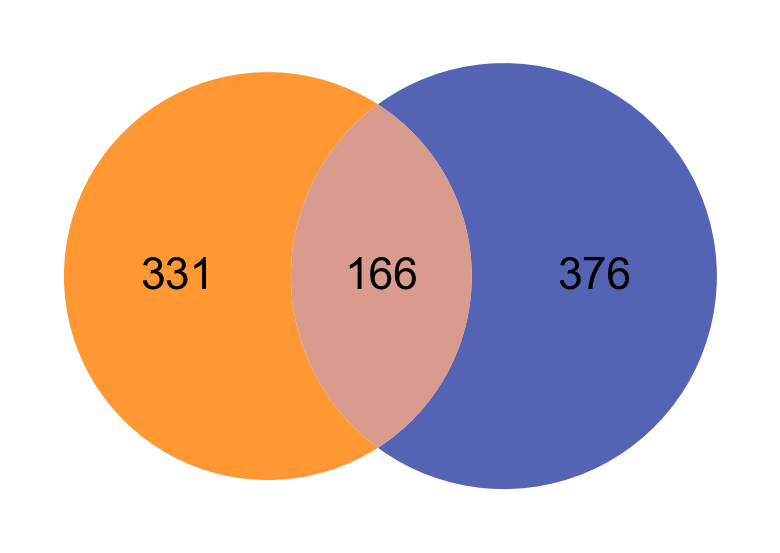

In [70]:
v2 = venn2([all_sig_genes,all_sig_genes_adult], set_labels=('',''),set_colors=('#ff7f00','#2A3CA1'),alpha=0.8)
for text in v2.subset_labels:
    text.set_fontsize(20)
# plt.savefig('figures/figure_10/all_DE_genes.pdf', bbox_inches='tight')

# GO term analysis

In [71]:
def load_Flymine(infile):
    terms = []
    pvalues = []
    num_genes = []
    GOs = []
    with open(infile) as f:
        for line in f:
            term = line.rstrip().split("\t")[0]
            pvalue = float(line.rstrip().split("\t")[1])
            n = len(line.rstrip().split("\t")[2].split(","))
            GO = line.rstrip().split("\t")[3]
            GOs.append(GO)
            terms.append(term)
            pvalues.append(pvalue)
            num_genes.append(n)
    df = pd.DataFrame({"term":terms, "GO": GOs, "pvalue": pvalues, "num_genes": num_genes})
    df.sort_values("pvalue", inplace=True, ascending=True)
    return df

In [72]:
num_hits = 10

Text(0.5, 0, '-log10(P value)')

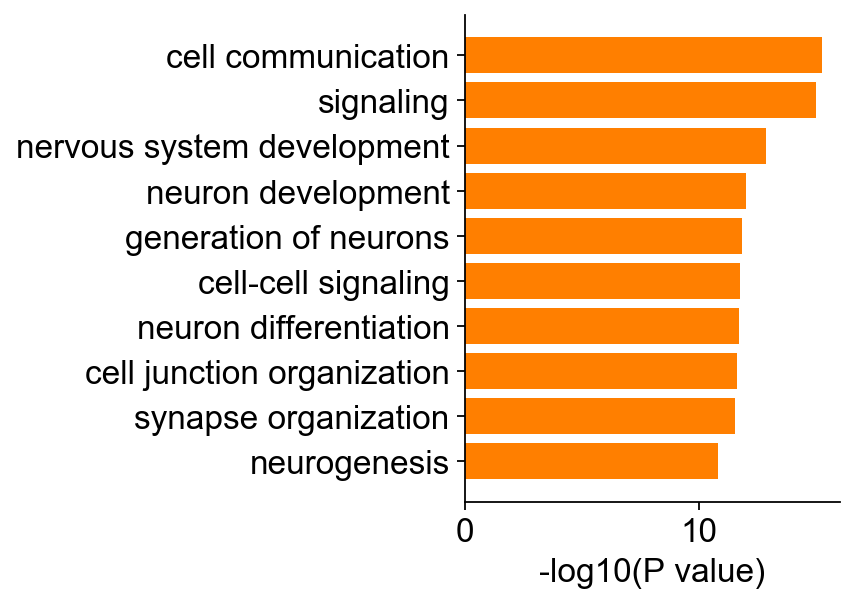

In [73]:
GO_24hAPF = load_Flymine("../output/GO_final/24h.tsv")
GO_24hAPF.term[0] = GO_24hAPF.term[0][1:]
myData = GO_24hAPF.head(n=num_hits)[::-1]

x = np.array(range(myData.shape[0]))
y = -np.log10(myData["pvalue"])
xticklabels = list(myData["term"])

fig, ax = plt.subplots(1, 1, figsize=(3,4))#5,8
ax.grid(False)
ax.barh(x, y, color= '#ff7f00')
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_yticks(x)
ax.set_yticklabels(xticklabels)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("-log10(P value)", fontsize=15)

# fig.savefig('figures/figure_10/GO_term/24h_only_top10.pdf', bbox_inches='tight')

Text(0.5, 0, '-log10(P value)')

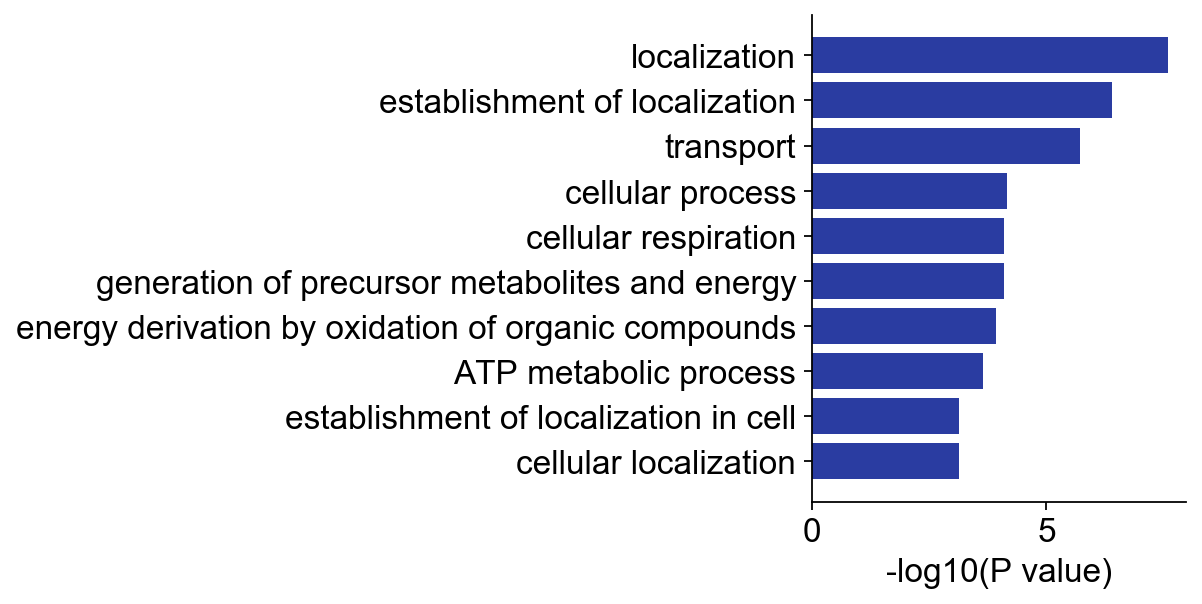

In [74]:
GO_adult = load_Flymine("../output/GO_final/adult.tsv")
GO_adult.term[0] = GO_adult.term[0][1:]
myData = GO_adult.head(n=num_hits)[::-1]

x = np.array(range(myData.shape[0]))
y = -np.log10(myData["pvalue"])
xticklabels = list(myData["term"])

fig, ax = plt.subplots(1, 1, figsize=(3,4))#5,8
ax.grid(False)
ax.barh(x, y, color= '#2A3CA1')
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_yticks(x)
ax.set_yticklabels(xticklabels)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("-log10(P value)", fontsize=15)

# fig.savefig('figures/figure_10/GO_term/adult_only_top10.pdf', bbox_inches='tight')

Text(0.5, 0, '-log10(P value)')

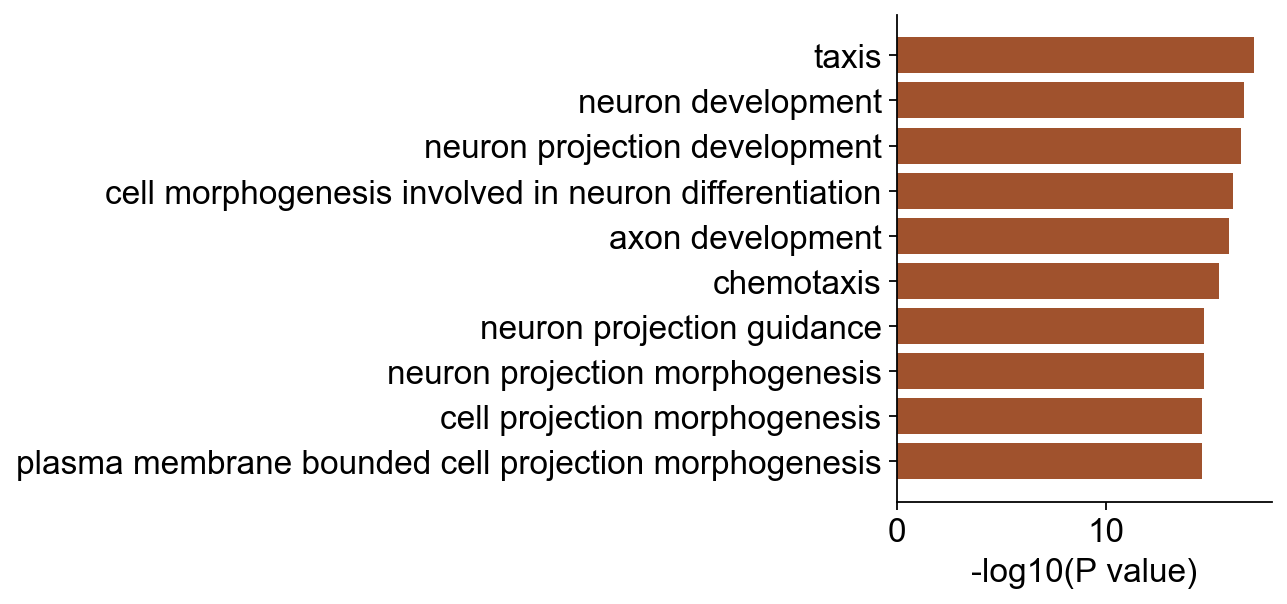

In [75]:
GO_common = load_Flymine("../output/GO_final/common.tsv")
GO_common.term[0] = GO_common.term[0][1:]
myData = GO_common.head(n=num_hits)[::-1]

x = np.array(range(myData.shape[0]))
y = -np.log10(myData["pvalue"])
xticklabels = list(myData["term"])

fig, ax = plt.subplots(1, 1, figsize=(3,4))#5,8
ax.grid(False)
ax.barh(x, y, color= '#a0522d')
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_yticks(x)
ax.set_yticklabels(xticklabels)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("-log10(P value)", fontsize=15)

# fig.savefig('figures/figure_10/GO_term/common_top10.pdf', bbox_inches='tight')

# adult DE genes by category

In [76]:
adult_DE_channels = set(all_sig_genes_adult).intersection(set(GG_channel))
adult_DE_channels = sorted(list(adult_DE_channels), key=lambda s: s.lower())
adult_receptors = set(all_sig_genes_adult).intersection(set(GG_receptors))
receptor_trimed = set(adult_receptors).difference(adult_DE_channels)
receptor_trimed = sorted(list(receptor_trimed), key=lambda s: s.lower())
dict_all_transmission = {'ion channels': adult_DE_channels, 
                         'transmembrane receptors': receptor_trimed}

In [78]:
adata_adult.obs.PN_type.cat.categories

Index(['D', 'DA1', 'DC3 and VA1d', 'DL1', 'DM6', 'MARS_19', 'MARS_2',
       'MARS_25', 'MARS_5', 'VA1v', 'VA6', 'VC2', 'VM2', 'VM7 or VM5v #1',
       'VM7 or VM5v #2', '2', '24', '5', '19', '9', '6', '23'],
      dtype='object')

In [79]:
PN_type_stage = ['VA6','DL1','D','DC3 and VA1d','VM7 or VM5v #1','VM2','DM6','VA1v','VM7 or VM5v #2',
                 'MARS_5','MARS_19','19','23','24','VC2','DA1','MARS_2','MARS_25','2','5','6','9']
adata_adult.obs.PN_type.cat.reorder_categories(PN_type_stage, inplace=True)

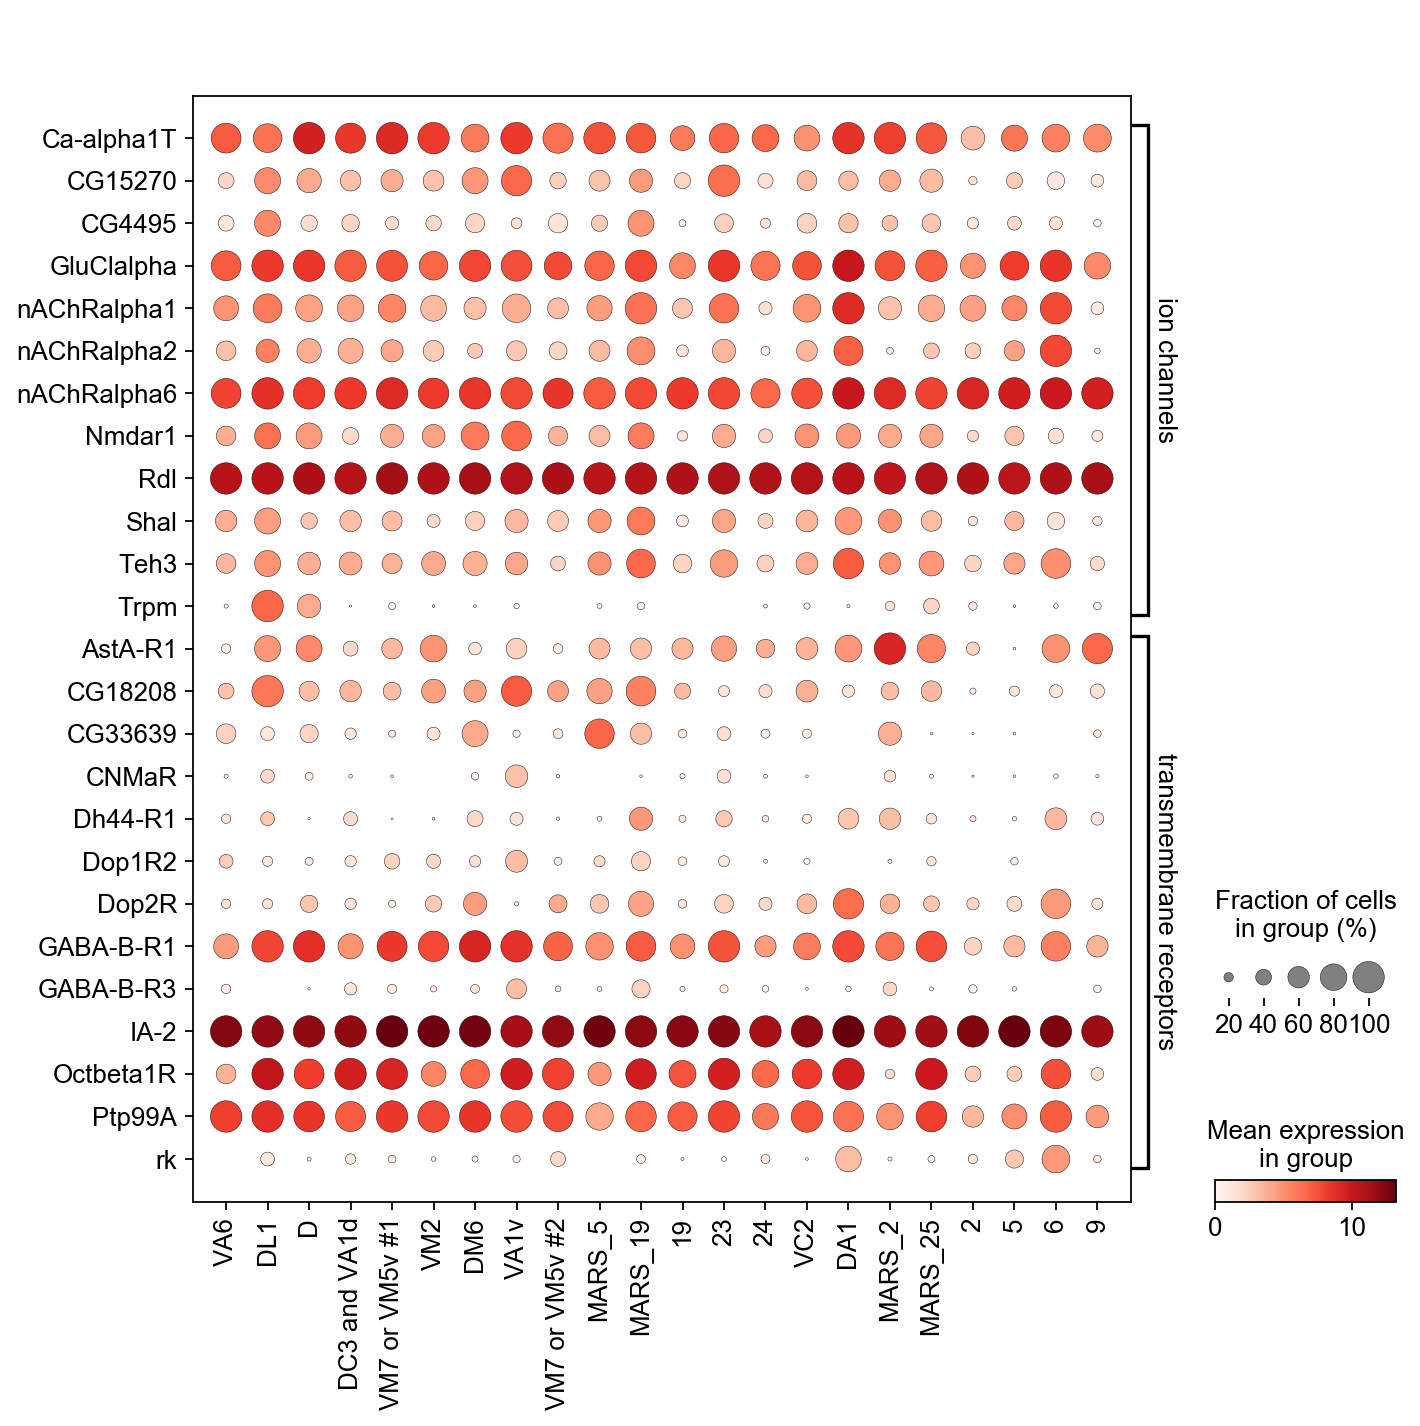

In [81]:
sc.pl.dotplot(adata_adult, var_names=dict_all_transmission, groupby='PN_type',swap_axes=True,
              save='_ionChannel_transmembraneReceptor.pdf')